In [1]:
import os
os.chdir('/data/l989o/deployed/a')
import sys
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')
print(os.getcwd())
import numpy as np
from jupy import *

/data/l989o/deployed/a


In [2]:
import h5py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import torch
import os

In [3]:
a = '/data/l989o/deployed/a/data/spatial_uzh_processed/a/'
instances = [os.path.join(a, s) for s in os.listdir(a) if 'vae_cell_dataset_expression_LR_VB_S_' in s or 'transformed_mean_dataset_LR_VB_S_' in s]
len(instances)

131

In [59]:
train_losses = dict()
validation_losses = dict()

train_klds = dict()
validation_klds = dict()

train_mses = dict()
validation_mses = dict()

for ll in instances:
    name = os.path.basename(ll)
    
    train_losses[name] = dict()
    validation_losses[name] = dict()
    
    train_klds[name] = dict()
    validation_klds[name] = dict()
    
    train_mses[name] = dict()
    validation_mses[name] = dict()
    
    with h5py.File(os.path.join(ll, 'training_logger.hdf5'), 'r') as f5:
        keys = f5.keys()
        epochs = sorted([int(k.split('epoch')[1]) for k in keys])
        sorted_epochs_strings = [f'epoch{epoch}' for epoch in epochs]
        for i, s in enumerate(sorted_epochs_strings):
            epoch = epochs[i]
            
            train_loss = f5[s]['training_evaluator']['loss'][...]
            train_losses[name][epoch] = train_loss
            validation_loss = f5[s]['validation_evaluator']['loss'][...]
            validation_losses[name][epoch] = validation_loss
            
            train_kld = f5[s]['training_evaluator']['kld'][...]
            train_klds[name][epoch] = train_kld
            validation_kld = f5[s]['validation_evaluator']['kld'][...]
            validation_klds[name][epoch] = validation_kld
            
            train_mse = f5[s]['training_evaluator']['mse'][...]
            train_mses[name][epoch] = train_mse
            validation_mse = f5[s]['validation_evaluator']['mse'][...]
            validation_mses[name][epoch] = validation_mse

train_traces = []
for name, losses in train_losses.items():
    visible = True
    if name in ['raw_vae']:
        visible = 'legendonly'
    trace = go.Scatter(x=list(losses.keys()), y=list(losses.values()), name=name, visible=visible)
    train_traces.append(trace)
validation_traces = []
for name, losses in validation_losses.items():
    visible = True
    if name in ['raw_vae']:
        visible = 'legendonly'
    trace = go.Scatter(x=list(losses.keys()), y=list(losses.values()), name=name, visible=visible)
    validation_traces.append(trace)

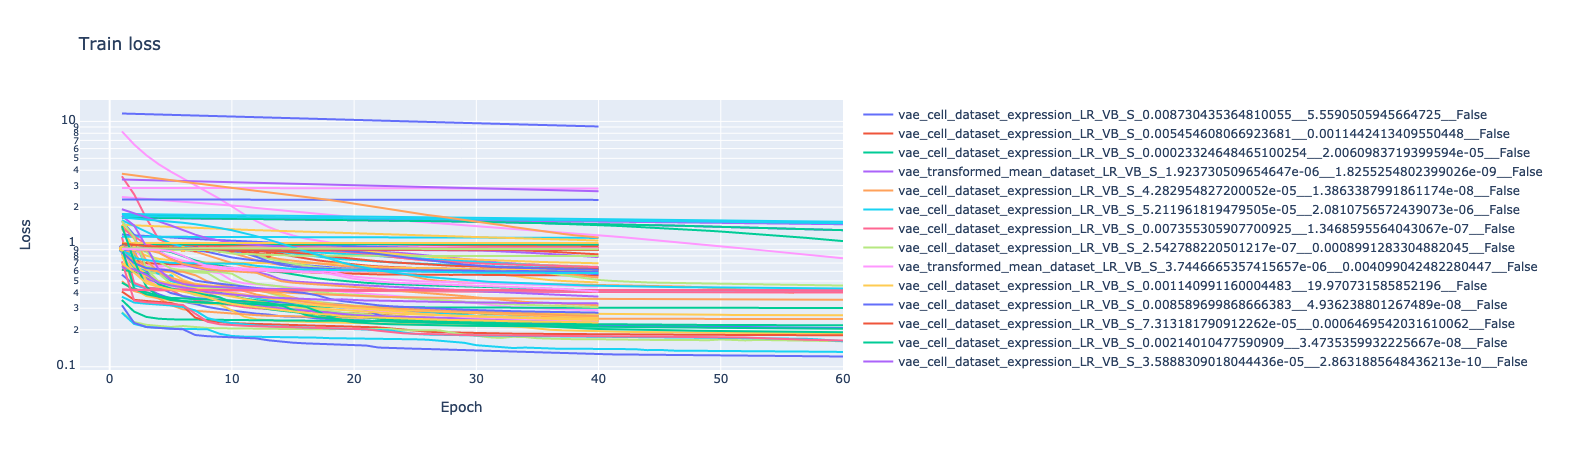

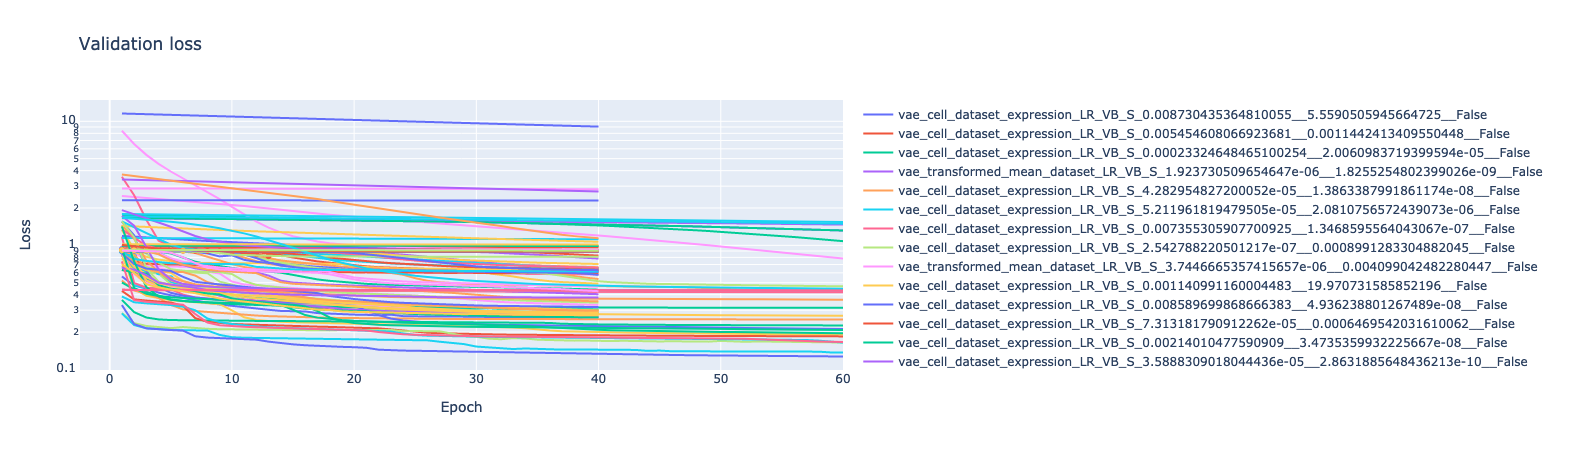

In [5]:
train_layout = go.Layout(
    title='Train loss',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    yaxis=dict(
        type='log'
    ),
)
fig = go.Figure(data=train_traces, layout=train_layout)
iplot(fig)

validation_layout = go.Layout(
    title='Validation loss',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    yaxis=dict(
        type='log'
    ),
)
fig = go.Figure(data=validation_traces, layout=validation_layout)
iplot(fig)


In [6]:
all_epochs = set()
for v in train_losses.values():
    all_epochs |= set(v.keys())

train_metrics_by_epoch = dict()
validation_metrics_by_epoch = dict()
for epoch in all_epochs:
    train_metrics_by_epoch[epoch] = dict()
    validation_metrics_by_epoch[epoch] = dict()
    for (k_train, v_train), (k_validation, v_validation) in zip(train_losses.items(), 
                                                                validation_losses.items()):
        assert k_train == k_validation
        vv_train = v_train[epoch] if epoch in v_train else None
        vv_validation = v_validation[epoch] if epoch in v_validation else None
        if vv_train is not None:
            train_metrics_by_epoch[epoch][k_train] = vv_train
        if vv_validation is not None:
            validation_metrics_by_epoch[epoch][k_validation] = vv_validation

#%%

# x and y are items of a dictionary, each of the values is either a float either None
# we sort the float ascendingly, and we consider the None as higher that every other value
l = lambda d: {k: {kk: vv for kk, vv in sorted(v.items(), key=lambda x: x[1])} for k, v in d.items()}
sorted_train = l(train_metrics_by_epoch)
sorted_validation = l(validation_metrics_by_epoch)

#%%

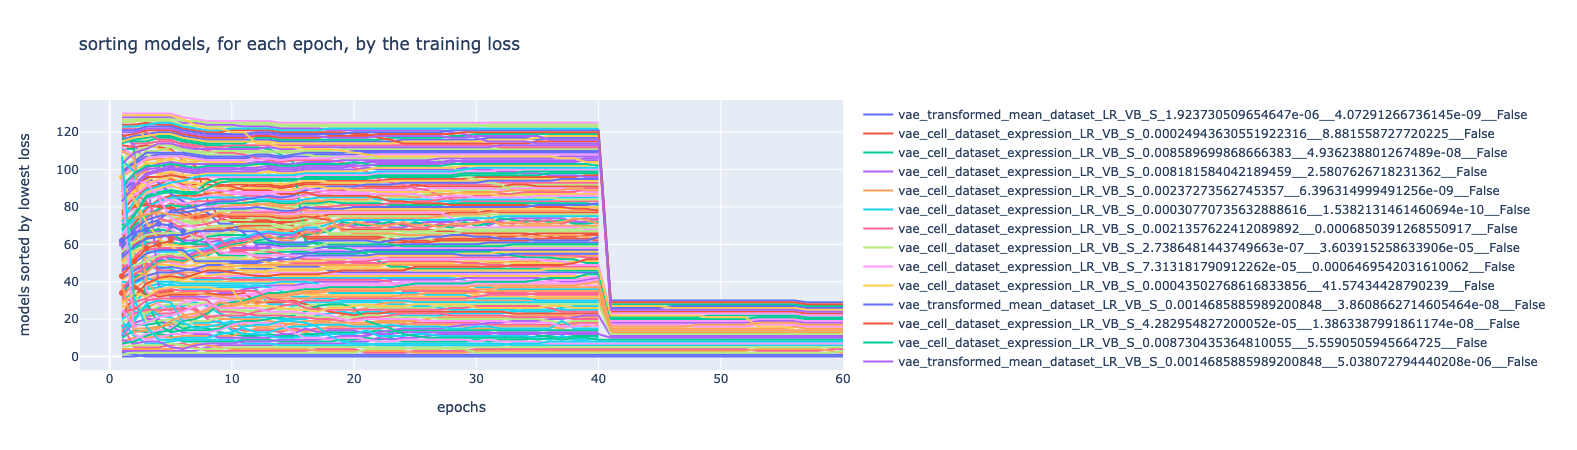

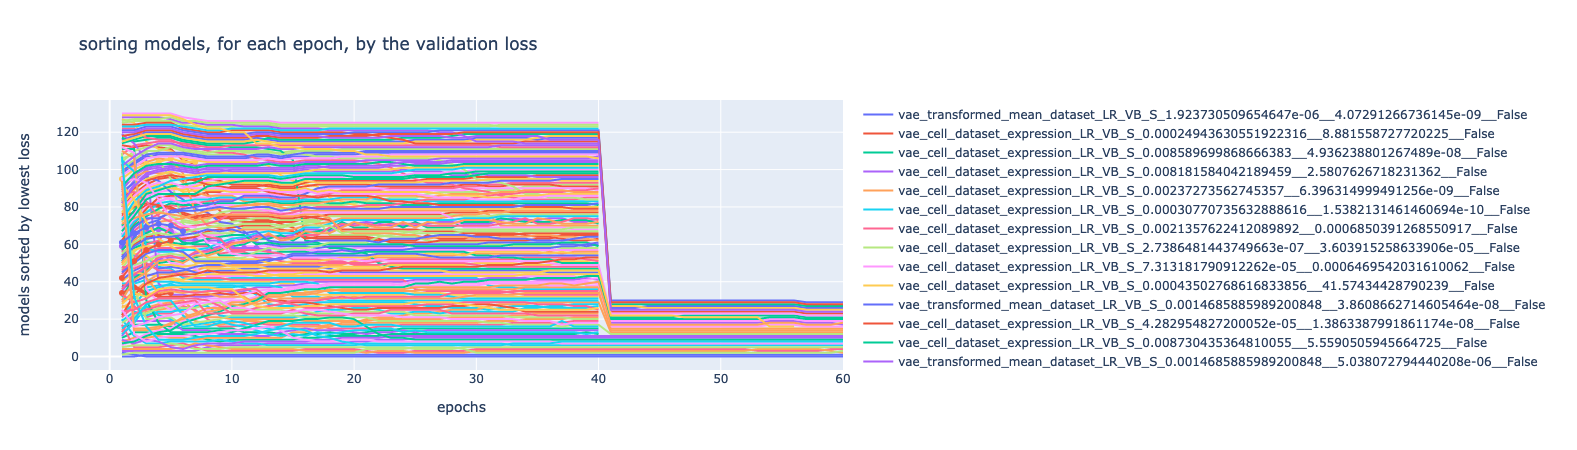

In [7]:
def plot_dict_of_sorted_metrics(d, loss_type):
    all_names = set()
    for v in d.values():
        names = set(v.keys())
        all_names |= names
    traces = {name: dict() for name in all_names}
    custom_data = {name: dict() for name in all_names}
    for epoch, sorted_names in d.items():
        for name in all_names:
            l = list(sorted_names.keys())
            if name in l:
                i = l.index(name)
                traces[name][epoch] = i
                custom_data[name][epoch] = sorted_names[name]
            
#     plt.figure(figsize=(16, 0.5 * len(all_names)))
    plotly_traces = []
    for name, trace in traces.items():
        x = list(trace.keys())
        y = list(trace.values())
        customdata = np.array(list(custom_data[name].values()))
        plotly_trace = go.Scatter(x=x, y=y, customdata=customdata, name=name, visible=visible, hovertemplate = '(%{x}, %{y}) loss: %{customdata:10.3e}')
        plotly_traces.append(plotly_trace)
#         plt.plot(x, y, label=name, linewidth=5)        
#     plt.legend()
#     plt.title(f'sorting models by {loss_type} loss, for each epoch')
#     plt.xlabel('epochs')
#     plt.ylabel('models sorted by lowest loss')
#     plt.show()
    layout = go.Layout(
        title=f'sorting models, for each epoch, by the {loss_type} loss',
        xaxis_title='epochs',
        yaxis_title='models sorted by lowest loss',      
    )
    fig = go.Figure(data=plotly_traces, layout=layout)
    iplot(fig)
    
from collections import OrderedDict
sorted_train = OrderedDict(sorted(sorted_train.items()))
sorted_validation = OrderedDict(sorted(sorted_validation.items()))
    
plot_dict_of_sorted_metrics(sorted_train, 'training')
plot_dict_of_sorted_metrics(sorted_validation, 'validation')

In [8]:
#%%

import itertools

# BE CAREFUL that if some models have not been trained until the last epoch, they could end up not being considered here while still being good models
# epoch = max(sorted_validation.keys())
epoch = 40
# assert epoch == 40
candidates = list(itertools.islice(sorted_validation[epoch].items(), 15))
pprint(candidates)
instances_names = [candidate[0] for candidate in candidates]
print(instances_names)

[('vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False',
  array(0.13227339)),
 ('vae_transformed_mean_dataset_LR_VB_S_0.007155682161754859__1.4135935551752293e-08__False',
  array(0.14408487)),
 ('vae_transformed_mean_dataset_LR_VB_S_0.007155682161754859__4.831596208381855e-07__False',
  array(0.16979348)),
 ('vae_transformed_mean_dataset_LR_VB_S_0.00025766385746135885__4.311710058685491e-08__False',
  array(0.17861684)),
 ('vae_transformed_mean_dataset_LR_VB_S_0.00015676677195506058__1.3981961408994041e-07__False',
  array(0.18065144)),
 ('vae_transformed_mean_dataset_LR_VB_S_0.0001871450068624066__5.981221901152551e-07__False',
  array(0.18782235)),
 ('vae_transformed_mean_dataset_LR_VB_S_0.00012229065947034362__7.991597087441535e-07__False',
  array(0.19953948)),
 ('vae_transformed_mean_dataset_LR_VB_S_0.0001__1e-06__False',
  array(0.20853953)),
 ('vae_transformed_mean_dataset_LR_VB_S_4.950159553733197e-05__8.663279761354552e-08__False',
  arr

In [9]:
best_old = 'vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False'
best_new = 'vae_cell_dataset_expression_LR_VB_S_0.008589699868666383__4.936238801267489e-08__False'
second_best_new = 'vae_cell_dataset_expression_LR_VB_S_0.0074335575232060925__1.768025883323886e-10__False'
third_best_new = 'vae_cell_dataset_expression_LR_VB_S_0.007355305907700925__1.3468595564043067e-07__False'

In [63]:
EPOCH = 40

new_models = [os.path.basename(i) for i in instances if 'vae_cell_dataset_expression_LR_VB_S_' in i]
import pandas as pd
import re
r = r'vae_cell_dataset_expression_LR_VB_S_(.*?)__(.*?)__False'
rows = []
for m in new_models:
    g = re.match(r, m).groups()
    lr = float(g[0])
    vb = float(g[1])
    if m in validation_metrics_by_epoch[EPOCH]:
        val_loss = validation_metrics_by_epoch[EPOCH][m].item()
    else:
        val_loss = float('nan')
        
    if EPOCH in validation_klds[m]:
        val_kld = float(validation_klds[m][EPOCH])
    else:
        val_kld = float('nan')

    if EPOCH in validation_mses[m]:
        val_mse = float(validation_mses[m][EPOCH])
    else:
        val_mse = float('nan')
        
    row = {'learning_rate': lr, 'vae_beta': vb, 'val_loss': val_loss, 'val_kld': val_kld, 'val_mse': val_mse, 'name': m}
    rows.append(row)
df = pd.DataFrame(rows, columns=['learning_rate', 'vae_beta', 'val_loss', 'val_kld', 'val_mse', 'name'])
print(df.dtypes)
display(df)

learning_rate    float64
vae_beta         float64
val_loss         float64
val_kld          float64
val_mse          float64
name              object
dtype: object


,learning_rate,vae_beta,val_loss,val_kld,val_mse,name
0,0.008730,5.559051e+00,0.891265,4.878864e-08,0.891265,vae_cell_dataset_expression_LR_VB_S_0.00873043...
1,0.005455,1.144241e-03,0.282917,1.391880e+01,0.266991,vae_cell_dataset_expression_LR_VB_S_0.00545460...
2,0.000233,2.006098e-05,0.439087,1.054842e+02,0.436971,vae_cell_dataset_expression_LR_VB_S_0.00023324...
3,0.000043,1.386339e-08,0.666414,1.213232e+01,0.666414,vae_cell_dataset_expression_LR_VB_S_4.28295482...
4,0.000052,2.081076e-06,0.636593,2.491572e+01,0.636541,vae_cell_dataset_expression_LR_VB_S_5.21196181...
...,...,...,...,...,...,...
97,0.009859,5.995826e-03,0.379505,6.690231e+00,0.339392,vae_cell_dataset_expression_LR_VB_S_0.00985897...
98,0.000029,3.501317e+01,1.139383,6.978567e-03,0.895041,vae_cell_dataset_expression_LR_VB_S_2.88874842...
99,0.000012,5.420638e-07,0.904507,1.172178e-01,0.904507,vae_cell_dataset_expression_LR_VB_S_1.15921911...
100,0.000206,1.998252e-08,0.426850,1.120636e+02,0.426848,vae_cell_dataset_expression_LR_VB_S_0.00020636...


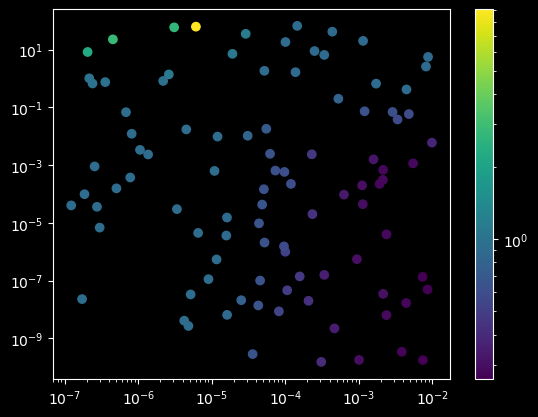

In [65]:
import seaborn as sns
import matplotlib
plt.style.use('dark_background')
im = plt.scatter(df['learning_rate'], y=df['vae_beta'], c=df['val_loss'], norm=matplotlib.colors.LogNorm())
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()
plt.style.use('default')

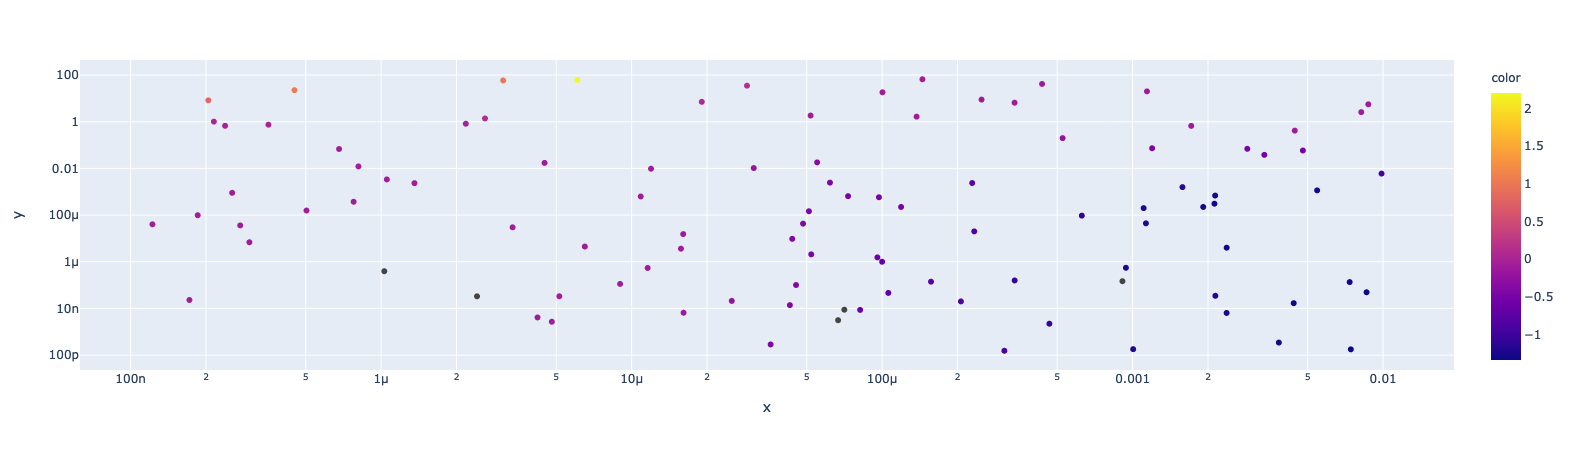

In [66]:
import plotly.express as px
fig = px.scatter(x=df['learning_rate'], y=df['vae_beta'], color=np.log(df['val_loss']), log_x=True, log_y=True)
fig.show()

In [38]:
candidate = df.loc[(0.005 < df['learning_rate']) & (df['learning_rate'] < 0.006), 'name'].item()
candidate

'vae_cell_dataset_expression_LR_VB_S_0.005454608066923681__0.0011442413409550448__False'

In [55]:
sorted_names = list(sorted_validation[40].keys())
assert sorted_names[0] == best_old
print(sorted_names.index(best_old))
print(sorted_names.index(best_new))
print(sorted_names.index(candidate))
print(len(sorted_names))

0
12
21
126


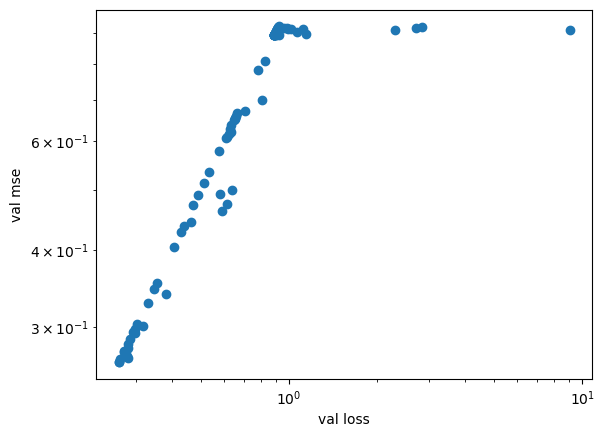

In [71]:
plt.scatter(df['val_loss'], df['val_mse'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('val loss')
plt.ylabel('val mse')
plt.show()

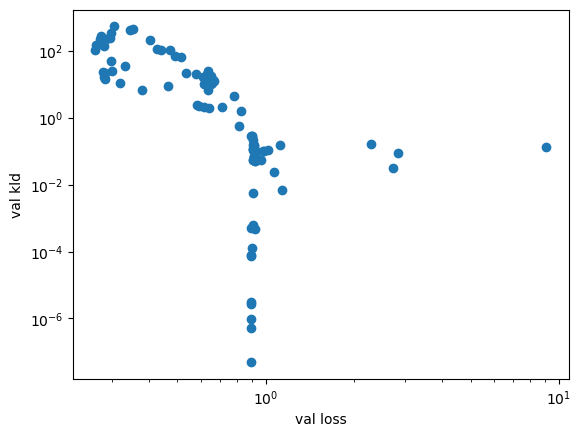

In [78]:
plt.scatter(df['val_loss'], df['val_kld'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('val loss')
plt.ylabel('val kld')
plt.show()

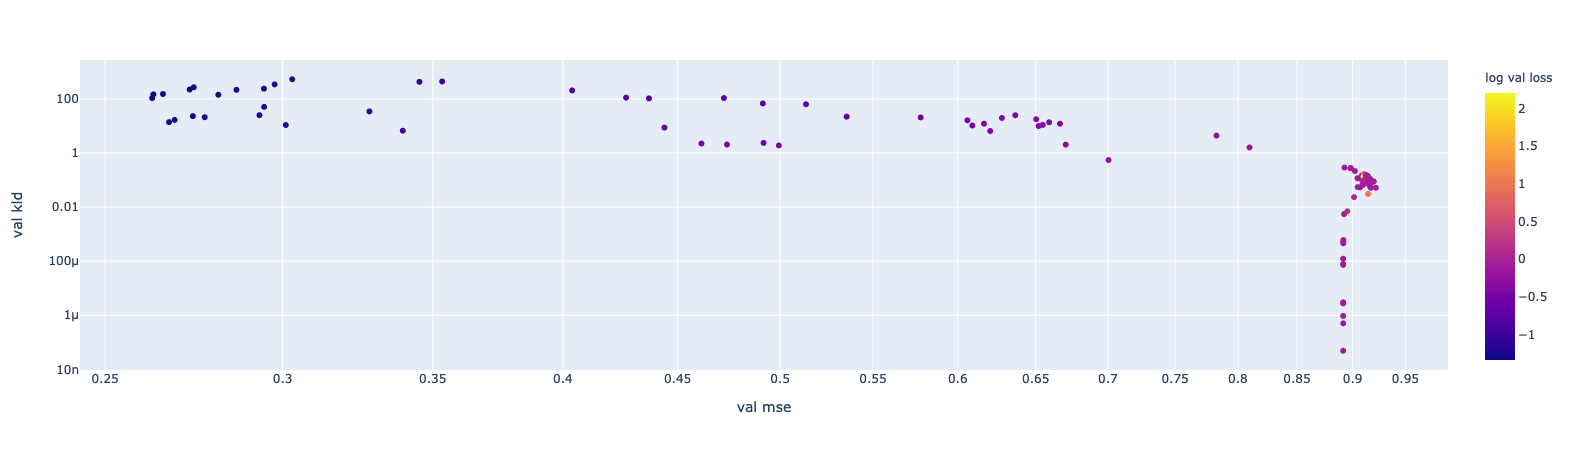

In [93]:
import plotly.express as px
fig = px.scatter(x=df['val_mse'], y=df['val_kld'], color=np.log(df['val_loss']), log_x=True, log_y=True)
fig.update_layout(
    xaxis_title='val mse',
    yaxis_title='val kld',
    coloraxis_colorbar=dict(
        title='log val loss',
    ),
)
fig.show()